In [1]:
import keras
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras import backend as K
import numpy as np
from keras import optimizers
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
from sklearn.datasets import fetch_mldata
from keras.datasets import cifar10,mnist
from keras.callbacks import ModelCheckpoint#save your model
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
(x_train, y_train_1),(x_test, y_test_1) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
x_train= x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test/= 255

In [4]:
img_rows=28
img_cols=28
if K.image_data_format() == 'channels_first':
    x_train_1 = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_1 = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_1 = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_1 = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print(x_train_1.shape)
print(y_train_1.shape)
print(y_test_1.shape)
print(x_test_1.shape)

(60000, 28, 28, 1)
(60000,)
(10000,)
(10000, 28, 28, 1)


In [19]:
#making even splits of validation and train set 
#x_train_1=x_train[:35000]
##y_train_1=y_train[:35000]
#x_add=x_train[35000:]
#y_add=y_train[35000:]
#x_test_1=np.vstack((x_add,x_test))
#y_test_1=np.hstack((y_add,y_test))
#print(x_test_1.shape)
#print(y_test_1.shape)
#print(x_train_1.shape)
#print(y_train_1.shape)

In [5]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped) 
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def batch_all_triplet_indices(grouped,n):
    num_classes=len(grouped)
    triples_indices = []
    for i in range(n):
        positive_index=np.random.randint(num_classes)
        positive_labels_indices=grouped[positive_index]
        positive=np.random.choice(positive_labels_indices)
        anchor=np.random.choice(positive_labels_indices)
        negative_index=np.random.randint(num_classes)
        while (negative_index == positive_index):
            negative_index=np.random.randint(num_classes)
        negative = np.random.choice(grouped[negative_index])
        triples_indices.append([anchor,positive, negative])
    return np.asarray(triples_indices) 

def get_triples_data(x, grouped, n):
    indices = batch_all_triplet_indices(grouped, n)
    return x[indices[:,0]], x[indices[:,1]], x[indices[:,2]]

In [6]:
def triplet_loss(inputs):
    margin=0.1
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    positive_distance = K.sqrt(K.sum(positive_distance, axis=1, keepdims=True))
    negative_distance = K.sqrt(K.sum(negative_distance, axis=1, keepdims=True))
    loss = positive_distance - negative_distance+margin
    loss=K.maximum(0.0,loss)
    return K.mean(loss)

def build_model(input_shape):
    base_input = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(base_input)
    x = Dropout(0.2)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    #kernel_regularizer=regularizers.l2(0.4)
    x = Dense(5,kernel_regularizer=regularizers.l2(0.3),activation='softmax')(x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x) # force the embedding onto the surface of an n-sphere
    embedding_model = Model(base_input, x, name='embedding')
    
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    sgd = optimizers.Adam(lr=0.001)
    triplet_model.compile(loss=None, optimizer=sgd, metrics=['accuracy'])

    return embedding_model, triplet_model

In [22]:
class accuracy(keras.callbacks.Callback):
     def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        return
        

IndentationError: unindent does not match any outer indentation level (<ipython-input-22-755ad9c81d5c>, line 5)

In [8]:
K.clear_session()
batch_size = 2000
steps_per_epoch = 5
epochs = 100
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
        
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x_train_1, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},None)
validation_steps=int(x_test_1.size/batch_size)
embedding_model, triplet_model = build_model((28,28,1))
validation_steps=int(x_test_1.size/batch_size)
history = triplet_model.fit_generator(triplet_generator(x_train_1, y_train_1, batch_size),steps_per_epoch=steps_per_epoch,
                                          epochs=epochs,verbose=1,validation_data=triplet_generator(x_test_1,y_test_1,batch_size),validation_steps=10,max_queue_size=1,workers=1)

Epoch 1/100
5/5 [==============================] - 27s 5s/step - loss: 2.8530 - val_loss: 2.4693
Epoch 2/100
5/5 [==============================] - 24s 5s/step - loss: 2.2008 - val_loss: 1.9085
Epoch 3/100
5/5 [==============================] - 24s 5s/step - loss: 1.6682 - val_loss: 1.4525
Epoch 4/100
5/5 [==============================] - 24s 5s/step - loss: 1.2442 - val_loss: 1.0922
Epoch 5/100
5/5 [==============================] - 24s 5s/step - loss: 0.9142 - val_loss: 0.8158
Epoch 6/100
5/5 [==============================] - 24s 5s/step - loss: 0.6623 - val_loss: 0.6078
Epoch 7/100
5/5 [==============================] - 24s 5s/step - loss: 0.4725 - val_loss: 0.4543
Epoch 8/100
5/5 [==============================] - 23s 5s/step - loss: 0.3364 - val_loss: 0.3426
Epoch 9/100
5/5 [==============================] - 22s 4s/step - loss: 0.2365 - val_loss: 0.2647
Epoch 10/100
5/5 [==============================] - 23s 5s/step - loss: 0.1675 - val_loss: 0.2108
Epoch 11/100
5/5 [===========

5/5 [==============================] - 23s 5s/step - loss: 0.0152 - val_loss: 0.1355
Epoch 85/100
5/5 [==============================] - 23s 5s/step - loss: 0.0159 - val_loss: 0.1349
Epoch 86/100
5/5 [==============================] - 23s 5s/step - loss: 0.0153 - val_loss: 0.1331
Epoch 87/100
5/5 [==============================] - 23s 5s/step - loss: 0.0150 - val_loss: 0.1342
Epoch 88/100
5/5 [==============================] - 22s 4s/step - loss: 0.0157 - val_loss: 0.1347
Epoch 89/100
5/5 [==============================] - 23s 5s/step - loss: 0.0153 - val_loss: 0.1362
Epoch 90/100
5/5 [==============================] - 23s 5s/step - loss: 0.0153 - val_loss: 0.1304
Epoch 91/100
5/5 [==============================] - 24s 5s/step - loss: 0.0143 - val_loss: 0.1337
Epoch 92/100
5/5 [==============================] - 24s 5s/step - loss: 0.0153 - val_loss: 0.1354
Epoch 93/100
5/5 [==============================] - 22s 4s/step - loss: 0.0146 - val_loss: 0.1361
Epoch 94/100
5/5 [===============

dict_keys(['loss', 'val_loss'])


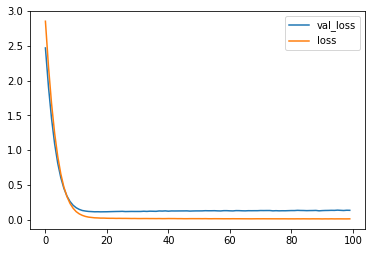

dict_keys(['loss', 'val_loss'])


In [9]:
print(history.history.keys())
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss') 
plt.legend()
plt.show()
print(history.history.keys())

In [21]:
emb_vecs = np.zeros((len(x_train_1),5))
for i,x in enumerate(x_train_1):
    x = (x/255).astype(np.float32)
    embedding_value= embedding_model.predict(np.expand_dims(x,axis=0))
    emb_vecs[i]=embedding_value/np.linalg.norm(embedding_value)

In [11]:
print(emb_vecs[1],emb_vecs[400])
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1- emb2)))

[0.47671002 0.47101951 0.43038431 0.43836725 0.41652337] [0.47682688 0.4709394  0.43052056 0.43807882 0.4166429 ]


In [22]:
from scipy import stats
def k_nearest_neighbor(embedding_values,labels,test_value,k): 
    '''calculates the k nearest neighbor a a given test_value and a particular k'''
    similar=np.zeros(len(embedding_values))
    for i,emb_vec in enumerate(embedding_values):
        similar[i] = distance(test_value,emb_vec)
    arrangement= np.argsort(similar)
    arrangement=arrangement[:k]
    k_nearest=labels[arrangement]
    correct_index_list=stats.mode(k_nearest)
    correct_index=correct_index_list[0].tolist()
    return correct_index[0]

In [23]:
test_image=x_train_1[101]
test_image=embedding_model.predict(np.expand_dims(test_image,axis=0))
correct_index=k_nearest_neighbor(emb_vecs,y_train_1,test_image,5)
print(correct_index)
print(y_train_1[101])

7
7


In [24]:
score=0
count=0
for i,x in enumerate(emb_vecs):
    pred=k_nearest_neighbor(emb_vecs,y_train_1,x,5)
    if (pred==y_train_1[i]):
        score=score+1
    if (count==20):
        break 
    count=count+1
print(score)

20


In [ ]:
score=triplet_model.evaluate(triplet_generator(x_test_1,y_test_1,batch_size),steps=100)

In [ ]:
predict=triplet_model.predict_generator(triplet_generator(x_test_1,y_test_1,batch_size),steps=100,workers=1)

test_image=x_train_1[4]
test_image=embedding_model.predict(np.expand_dims(test_image,axis=0))
correct_index=k_nearest_neighbor(emb_vecs,y_train_1,test_image,5)
print(correct_index)
print(y_train_1[3])

In [25]:
logdir="./Desktop/logdir"
tf.reset_default_graph()
session=tf.Session()
embedding_var=tf.Variable(emb_vecs,name='mnist_embedding')
saver=tf.train.Saver()
session.run(tf.global_variables_initializer())
saver.save(session,os.path.join(logdir,"model.ckpt"))

'./Desktop/logdir/model.ckpt'

In [26]:
def write_meta_file(savedir, labels):
    with open(savedir+"/metadata.tsv", "w") as metafile:
        string_array = []
        for label in labels:
            string_array.append(str(label)+"\n")
        metafile.writelines(string_array)

In [27]:
write_meta_file(logdir,y_train_1)